# Newton, Univariate and Fletcher-Reeves optimization algorithms

In [1]:
import numpy as np
from sympy.solvers import solve
from sympy import Symbol,lambdify
import sympy as sp

## Vanilla Newton 

The `Newton()` is the "vanilla" Newton method implemented as in the Rao book. Every new iteration is updated with first ($\nabla f_i$) and second order ($\mathbf{J}_i$) derivative information. A new canditade optimum point is defined as 

$$
\begin{array}{lll}
  \mathbf{x}_{i + 1} & = & \mathbf{x}_i -\mathbf{J}_i^{- 1} \nabla f_i
\end{array}
$$

In [ ]:
def Newton(fun_, vars, x0, it=10, tol=0, verbose=False):
    gradi2=tol
    for i in range(it):    
        if i==0:
            xi = x0
        else:
            xi = xi2

        J = np.array([[lambdify(vars,sp.diff((sp.diff(fun_(vars),xi_)),x__))(*xi) for xi_ in vars] for x__ in vars])
        gradi = np.array([lambdify(vars,sp.diff(fun_(vars),xi_))(*xi) for xi_ in vars])
        gradi_sym = np.array([sp.diff(fun_(vars),xi_) for xi_ in vars])
        J_sym = np.array([[sp.diff((sp.diff(fun_(vars),xi_)),x__) for xi_ in vars] for x__ in vars])
        
        fval = fun_(xi)
        
        if verbose:
            print('it. {} - f: {}'.format(i+1, fval))
            print('x{}T: {}'.format(i+1, xi))
            print('grad_{}: {} = {}'.format(i+1,gradi_sym,gradi))
            print('J_{}: {} = {}'.format(i+1,J_sym,J))
            print('J_inv{}: {}'.format(i+1, np.linalg.inv(J) ))
            print()

        if np.linalg.norm(gradi2) < tol:
            return xi, fval
        
        xi2 = xi - np.linalg.inv(J) @ gradi
        gradi2 = np.array([lambdify(vars,sp.diff(fun_(vars),xi_))(*xi) for xi_ in vars])

    return xi, fval, it


## Newton with improved step search

The `Newton2()` is the Newton method enhanced with an optimun step lenght ($\lambda_i$).

$$
\begin{array}{lll}
  \mathbf{x}_{i + 1} & = & \mathbf{x}_i + \lambda_i \mathbf{J}_i^{- 1} \nabla f_i
\end{array}
$$

The $\lambda_i$ step is found by minimizing a single variable optimization problem defined by

$$
\frac{\partial f (\mathbf{x}_i + \lambda_i \mathbf{s}_i)}{\partial
\lambda_i} = 0
$$

This optimum step search was implemented in `getLambda()` function.

In [ ]:
def getLambda(fun_, xi, si):
    # function to solve the single variable optimation fo tind the best step into search direction
    l = Symbol('lambda')
    dfx = sp.diff(fun(xi + l*si))
    L = solve(dfx, numerical=True)
    L = np.array([float(sp.re(el)) for el in L])
    evals = np.array([fun_(xi+Li*si) for Li in L])
    return L[np.argmin(evals)]

In [ ]:
def Newton2(fun_, vars, x0, it=10, tol=0, verbose=False):
    gradi2 = tol
    for i in range(it):
        if i==0:
            xi = x0
        else:
            xi = xi2
            
        J = np.array([[lambdify(vars,sp.diff((sp.diff(fun_(vars),xi_)),x__))(*xi) for xi_ in vars] for x__ in vars])
        gradi = np.array([lambdify(vars,sp.diff(fun_(vars),xi_))(*xi) for xi_ in vars])
        gradi_sym = np.array([sp.diff(fun_(vars),xi_) for xi_ in vars])
        J_sym = np.array([[sp.diff((sp.diff(fun_(vars),xi_)),x__) for xi_ in vars] for x__ in vars])
        
        fval = fun_(xi)
        
        if verbose:
            print('it. {} - f: {}'.format(i+1, fval))
            print('x{}T: {}'.format(i+1, xi))
            print('grad_{}: {} = {}'.format(i+1,gradi_sym,gradi))
            print('J_{}: {} = {}'.format(i+1,J_sym,J))
            print('J_inv{}: {}'.format(i+1, np.linalg.inv(J) ))
            print()
        
        if np.linalg.norm(gradi2) < tol:
            return xi, fval

        L = getLambda(fun_, xi, np.linalg.inv(J) @ gradi)
        xi2 = xi + L*np.linalg.inv(J) @ gradi
        gradi2 = np.array([lambdify(vars,sp.diff(fun_(vars),xi_))(*xi) for xi_ in vars])

    return xi, fval, it

## Univariate method

The `Univariate()` method is the simplest one implemented, no information about derivatives are required, but impressive results can be found in the sample problem.

In [ ]:
def Univariate(fun_,vars, x0, it=10, eps=1e-3, tol=0, verbose=False):
    for i in range(it):
        if i==0:
            xi = x0
        else:
            xi = xi + sign*L*si

        if i % 2 == 0:
            si = np.array([1, 0])
        else:
            si = np.array([0, 1])

        fi = fun_(xi)
        xip = xi + eps*si
        fip = fun_(xip)
        xim = xi - eps*si
        fim = fun_(xim)
        
        if fip < fi:
            sign = 1
        elif fim < fi:
            sign = -1
        
        L = getLambda(fun_, xi, sign*si)

        if i>0 and abs(fun_(xi) - fval) < tol:
            break
        else:
            fval = fun_(xi)
        
        if verbose:
            print('it. {} - f: {}'.format(i+1, fval))
            print('x{}T: {}'.format(i+1, xi))
            print()

    return xi, fval, it

## Vanilla Fletcher-Reeves
The `FletcherReeves()` implements the Fletcher-Reeves algorithm with a step search using the smallest root of the polynomial function 

$$
\frac{\partial f (\mathbf{x}_i + \lambda_i \mathbf{s}_i)}{\partial
\lambda_i} = 0
$$

In [ ]:
def FletcherReeves(fun_, vars,  x0, it=10, tol=0, verbose=False):
    l = Symbol('lambda')
    for i in range(it):
        if i==0:
            xi = x0
        
        # search direction
        gradi = np.array([lambdify(vars,sp.diff(fun_(vars),xi_))(*xi) for xi_ in vars])
        gradi_sym = np.array([sp.diff(fun_(vars),xi_) for xi_ in vars])
        
        if i==0 or (i+1) % (len(vars)+1)==0:
            si = -gradi
            gradi_1 = np.zeros_like(gradi)
            si_1 = np.zeros_like(si)
        else:
            bi_1 = np.linalg.norm(gradi)**2/np.linalg.norm(gradi_1)**2
            si = -gradi+bi_1*si_1
    
        fval = fun_(xi)
         
        if np.linalg.norm(si) > tol:
            dfx = sp.diff(fun_(xi + l*si))
            L = solve(dfx, numerical=True)
            L = min([float(sp.re(sp.Abs(el))) for el in L])
            xi = xi + L*si
        else:
            return xi, fval 
        
        if verbose:
            print('it. {} - f: {}'.format(i+1, fval))
            print('x{}T: {}'.format(i+1, xi))
            print('grad_{}: {} = {}'.format(i+1,gradi_sym,gradi))
            print('s_{}: {}'.format(i+1,si))
            print('x*T: {}'.format(xstar))
            print('df(x*T)/dlambda{}: {}'.format(i+1,dfx))
            print('lambda{}: {}'.format(i+1,L))
            print()
        gradi_1[:] = gradi[:]
        si_1[:] = si[:]
    return xi, fval, it

## Fletcher-Reeves with improved step search

On the other hand `FletcherReeves2()` use the `getLambda()` function to find the optimum step, defined as the step that results in the minimal objective function value.

In [2]:
def FletcherReeves2(fun_, vars,  x0, it=10, tol=0, verbose=False):
    gradi_1=0
    for i in range(it):
        if i==0:
            xi = x0
        
        # search direction
        gradi = np.array([lambdify(vars,sp.diff(fun_(vars),xi_))(*xi) for xi_ in vars])

        gradi_sym = np.array([sp.diff(fun_(vars),xi_) for xi_ in vars])
        
        
        if i==0 or (i+1) % (len(vars)+1)==0:
            si = -gradi
            gradi_1 = np.zeros_like(gradi)
            si_1 = np.zeros_like(si)
        else:
            bi_1 = np.linalg.norm(gradi)**2/np.linalg.norm(gradi_1)**2
            si = -gradi+bi_1*si_1

        fval = fun_(xi)

        if np.linalg.norm(gradi_1) >= tol:
            l = Symbol('lambda')
            xstar = xi + l*si    
            dfx = sp.diff(fun(xstar))
            L = getLambda(fun_, xi, si)
            xi = xi + L*si
        else:
            return xi, fval

        if verbose:
            print('it. {} - f: {}'.format(i+1, fval))
            print('x{}T: {}'.format(i+1, xi))
            print('grad_{}: {} = {}'.format(i+1,gradi_sym,gradi))
            print('s_{}: {}'.format(i+1,si))
            print('x*T: {}'.format(xstar))
            print('df(x*T)/dlambda{}: {}'.format(i+1,dfx))
            print('lambda{}: {}'.format(i+1,L))
            print()

        gradi_1[:] = gradi[:]
        si_1[:] = si[:]
        
    return xi, fval, it

# Sample Problem

We want to find the minimum of the objective function

$$
f (\mathbf{x}) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2
$$

All four algorithms `Newton()`,`Newton2()`,`FletcherReevs()` and `FletcherReeves2()`.

In [15]:
import time

def fun(x):
    x1 = x[0]
    x2 = x[1]
    return 100.0*(x2-x1**2.0)**2.0+(1.0-x1)**2.0

x1=Symbol('x1')
x2=Symbol('x2')
vars = [x1,x2]
x0 = [-1.2, 1.0]
it = 30
methods = {Newton:'Newton',
           Newton2:'Newton2',
           FletcherReeves:'FlecherReeves',
           FletcherReeves2:'FletcherReeves2',
           Univariate:'Univariate'}
points = []           
for method,name in methods.items():
    s = time.time()
    xopt, fopt, it = method(fun, vars, x0, it=it)

    points.append([xopt[0],xopt[1],fopt])
    
    e = time.time()
    print(name+' method:')
    print('xopt: {}'.format(xopt))
    print('fopt: {}'.format(fopt))
    print('it: {}'.format(it))
    print('time(s): {}'.format(e-s))
    print()

Newton method:
xopt: [1. 1.]
fopt: 0.0
it: 30
time(s): 1.1884315013885498

Newton2 method:
xopt: [0.99999999 0.99999998]
fopt: 4.859791998968371e-16
it: 30
time(s): 18.247807502746582

FlecherReeves method:
xopt: [1.         0.99999999]
fopt: 1.5267761477425057e-17
it: 30
time(s): 17.15538787841797

FletcherReeves2 method:
xopt: [1.00000001 1.00000002]
fopt: 7.702171387438434e-17
it: 30
time(s): 14.291535377502441

Univariate method:
xopt: [1. 1.]
fopt: 4.930380657631324e-32
it: 30
time(s): 1.3788270950317383



The performance can be evaluated in terms of accuracy, i.e., how close the algorithm gets to the analytical solution $\mathbf{x}_{opt}^T = \left\{ \begin{array}{cc}1.0 & 1.0\end{array} \right\}$ at witch the objective function is $f(\mathbf{x}_{opt})=0$, and also by the computational timesteps required to a given accuracy. Here the wall-clock time have not much significance because some functions uses expensive symbolic computation to solve the equations, a feature not required for real world applications.

The robustness and validity of the four methods can be addressed by showing all of them get very close results as pictured below.

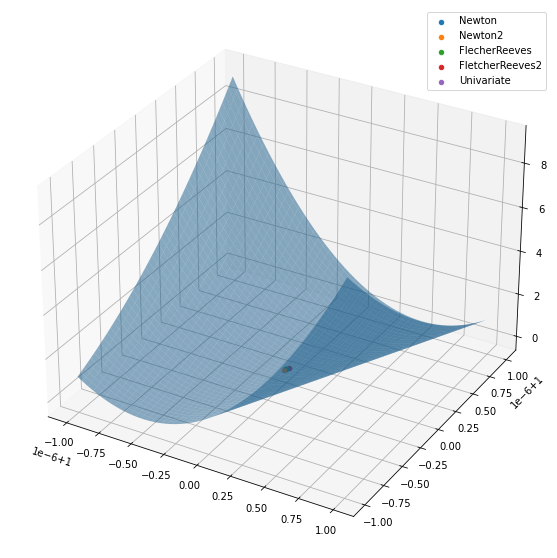

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})

Nx = 100
Ny = 100
x0 = 0.999999
x1 = 1.000001
y0 = 0.999999
y1 = 1.000001

X,Y = np.meshgrid(np.linspace(x0,x1,Nx), 
                  np.linspace(y0,y1,Ny))
Z = fun([X,Y])
ax.plot_surface(X,Y,Z,alpha=0.5)
for p,method in zip(points,methods.values()):
    ax.scatter(p[0],p[1],p[2], label=method)
ax.legend()